In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("santurini/semantic-segmentation-drone-dataset")   # Multiclass segmentation + unsplitted

print("Path to dataset files:", path)


100%|██████████| 4.83G/4.83G [02:02<00:00, 42.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/santurini/semantic-segmentation-drone-dataset/versions/2


In [2]:
import torch
import torch.nn as nn
import numpy as np
import os
import glob
from torch.utils.data import Dataset
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [3]:
def remap_mask(mask):
    # Remaps values to 0, 1, 2... based on unique values present
    mask = mask.long() # Segmentation masks must be LongTensor
    unique_values = torch.unique(mask)
    remapped_mask = torch.zeros_like(mask)

    for new_val, old_val in enumerate(sorted(unique_values.tolist())):
        remapped_mask[mask == old_val] = new_val

    return remapped_mask

class MulticlassDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None, mask_transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # 1. Load Image & Mask
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L") # Keep as L (grayscale)

        # 2. Apply Transform
        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        # 3. Remap Mask (we need this because CrossEntropy requires the labels to be consecutive)
        mask = remap_mask(mask)

        return image, mask


# Let's assume the data is not splitted here, we will use only the training folder, then split it.
# 1. Define Paths
root_dir = os.path.join(path, "semantic_drone_dataset", "semantic_drone_dataset")
all_images = sorted(glob.glob(f"{root_dir}/original_images/*.jpg"))
all_masks  = sorted(glob.glob(f"{root_dir}/label_images_semantic/*.png")) # Check extension!

# 2. Split Data
train_imgs, test_imgs, train_masks, test_masks = train_test_split(
    all_images, all_masks, test_size=0.2, random_state=42
)

class SubtractOne(nn.Module):
  def forward(self, img):
    return img-1

# 3. Define Transform
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()         # ToTensor does two things: Convert to tensor + scaling (divide by 255)
])
transform_mask = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.PILToTensor(), # PILToTensor does one thing: Convert to tensor only (mask should not be scaled!!)
    SubtractOne()

])

# 4. Create Datasets
train_dataset = MulticlassDataset(train_imgs, train_masks, transform=transform, mask_transform=transform_mask)
test_dataset  = MulticlassDataset(test_imgs,  test_masks,  transform=transform, mask_transform=transform_mask)

# 5. Check Output
img, mask = train_dataset[0]
print(f"Img Shape: {img.shape}")
print(f"Mask Shape: {mask.shape}")
print(f"Unique Classes: {torch.unique(mask)}")

Img Shape: torch.Size([3, 256, 256])
Mask Shape: torch.Size([1, 256, 256])
Unique Classes: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22])


In [4]:
train_loader = DataLoader(train_dataset,batch_size=4, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=2)

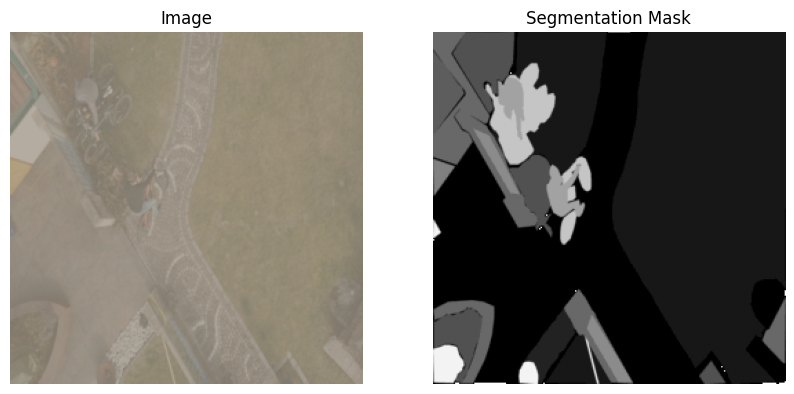

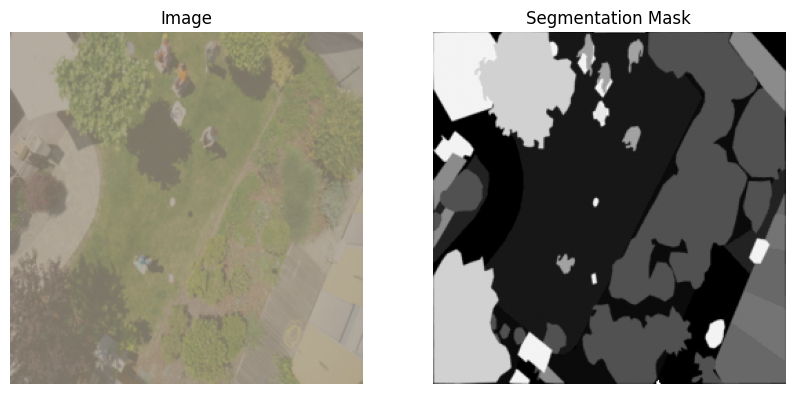

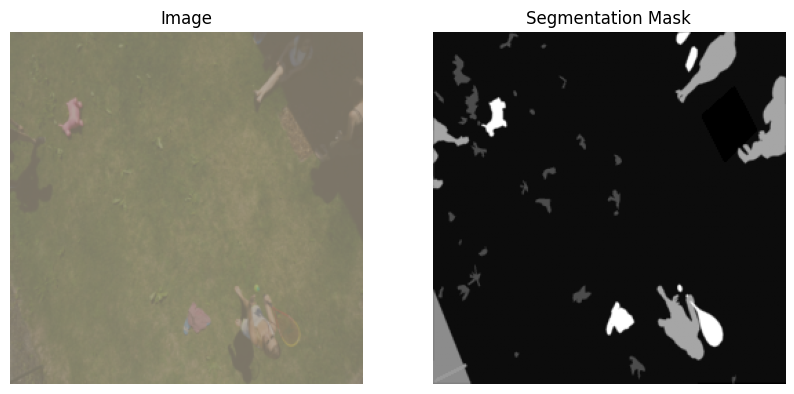

In [5]:
# Function to denormalize images (We cannot show normalized images. We have to reverse normalizaion first.)
def denormalize(img):
    mean = np.array([0.485, 0.456, 0.406])  # ImageNet mean
    std = np.array([0.229, 0.224, 0.225])  # ImageNet std
    img = img.numpy().transpose(1, 2, 0)  # Convert to HWC
    img = img * std + mean  # Reverse normalization
    img = np.clip(img, 0, 1)  # Clip values to [0,1]
    return img

# Display some images with their masks
for i in range(3):
    img, mask = train_dataset[i]
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(denormalize(img))
    axes[0].set_title("Image")
    axes[0].axis("off")
    axes[1].imshow(mask.permute(1,2,0), cmap="gray")
    axes[1].set_title("Segmentation Mask")
    axes[1].axis("off")
    plt.show()

In [6]:
!pip install -q segmentation_models_pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 7.8 MB/s eta 0:00:00


In [7]:
import segmentation_models_pytorch as smp

# Define U-Net Model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = smp.Unet(
    encoder_name="efficientnet-b0",  # Pretrained encoder (backbone)
    encoder_weights="imagenet",  # Use ImageNet weights
    in_channels=3,  # RGB images
    classes=24,
).to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [8]:
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

# 🔹 Training Loop
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0

    for images, masks in tqdm(dataloader):
        images, masks = images.to(device), masks.to(device).squeeze(dim=1).to(torch.long)  # mask shape becomes [N, H, W]

        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

# 🔹 Validation Loop
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device).squeeze(dim=1).to(torch.long)    # mask shape becomes [N, H, W]

            outputs = model(images)  # Now [N, H, W]
            loss = criterion(outputs, masks)
            total_loss += loss.item()

    return total_loss / len(dataloader)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

num_epochs =20  # Define number of epochs
train_losses = []
val_losses = []

# Training Loop
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = validate(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")


100%|██████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch 1/20: Train Loss = 2.9233, Val Loss = 2.7185


100%|██████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch 2/20: Train Loss = 2.2689, Val Loss = 2.3386


100%|██████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch 3/20: Train Loss = 1.8733, Val Loss = 1.8624


100%|██████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch 4/20: Train Loss = 1.6637, Val Loss = 1.5812


100%|██████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch 5/20: Train Loss = 1.5039, Val Loss = 1.3751


100%|██████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch 6/20: Train Loss = 1.3965, Val Loss = 1.2896


100%|██████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch 7/20: Train Loss = 1.3317, Val Loss = 1.2141


100%|██████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch 8/20: Train Loss = 1.2778, Val Loss = 1.1899


100%|██████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch 9/20: Train Loss = 1.2302, Val Loss = 1.1426


100%|██████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch 10/20: Train Loss = 1.2010, Val Loss = 1.1246


100%|██████████| 80/80 [01:26<00:00,  1.09s/it]


Epoch 11/20: Train Loss = 1.1640, Val Loss = 1.0958


100%|██████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch 12/20: Train Loss = 1.1258, Val Loss = 1.0846


100%|██████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch 13/20: Train Loss = 1.1058, Val Loss = 1.0570


100%|██████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch 14/20: Train Loss = 1.0717, Val Loss = 1.0357


100%|██████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch 15/20: Train Loss = 1.0451, Val Loss = 1.0442


100%|██████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch 16/20: Train Loss = 1.0200, Val Loss = 1.0105


100%|██████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch 17/20: Train Loss = 0.9793, Val Loss = 1.0010


100%|██████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch 18/20: Train Loss = 0.9738, Val Loss = 0.9984


100%|██████████| 80/80 [01:26<00:00,  1.08s/it]


Epoch 19/20: Train Loss = 0.9504, Val Loss = 0.9684


100%|██████████| 80/80 [01:26<00:00,  1.09s/it]


Epoch 20/20: Train Loss = 0.9416, Val Loss = 0.9388


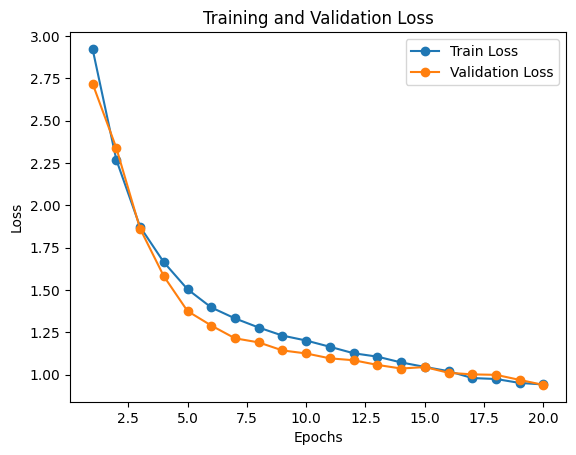

In [10]:
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

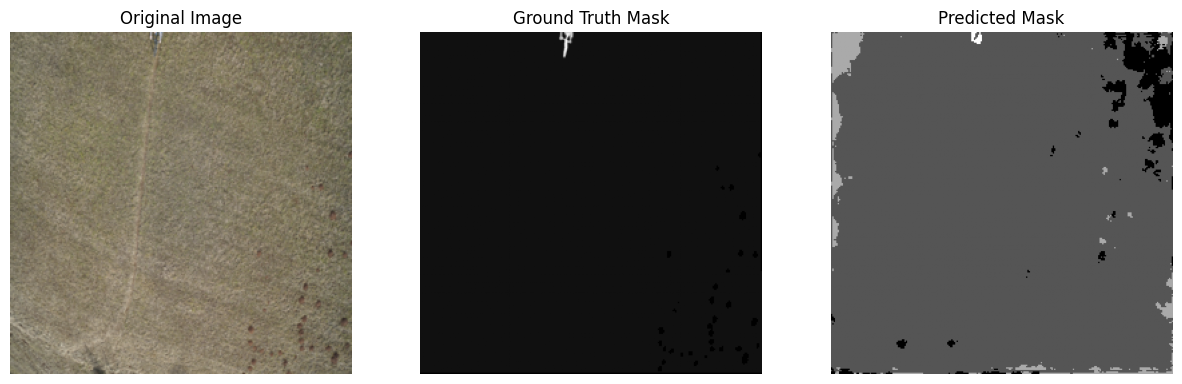

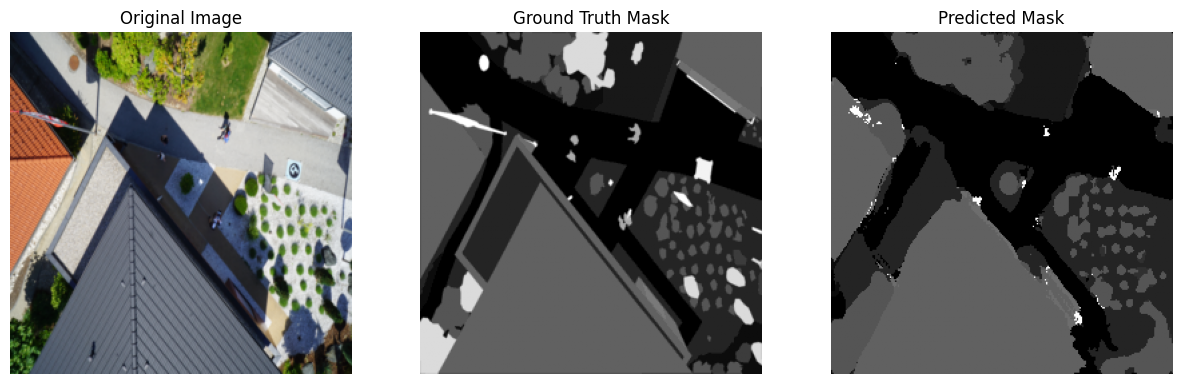

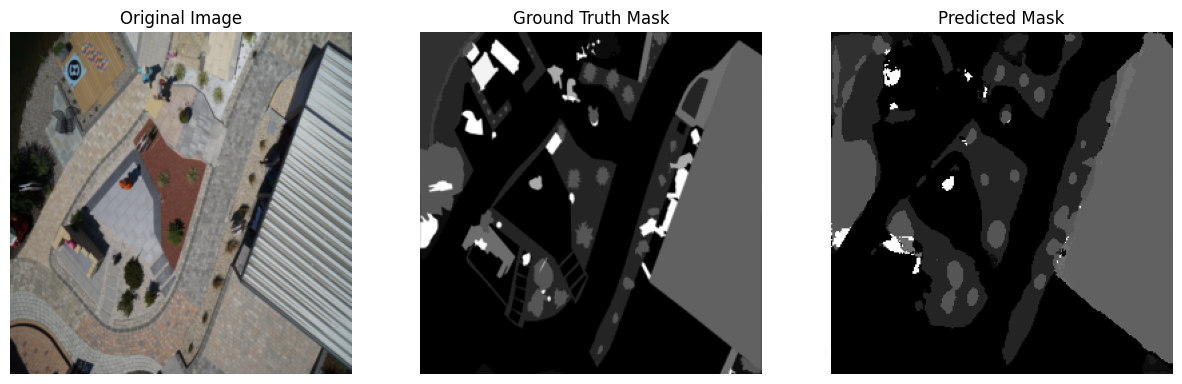

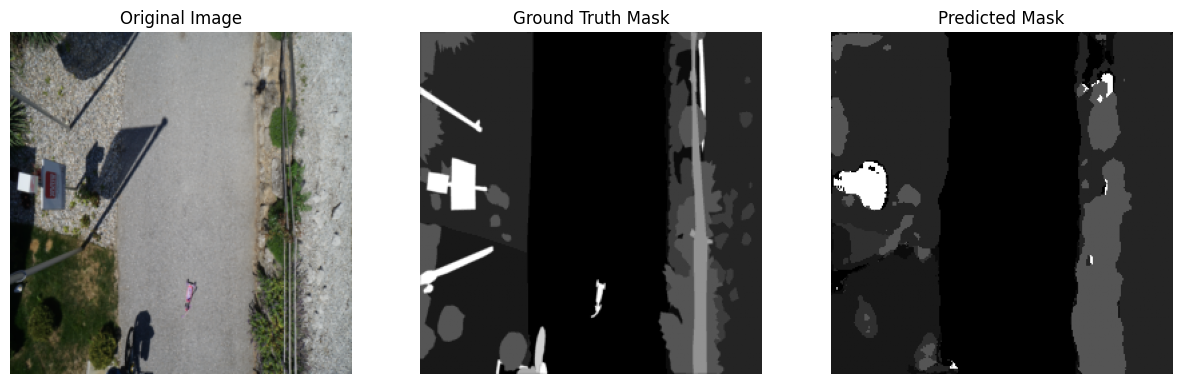

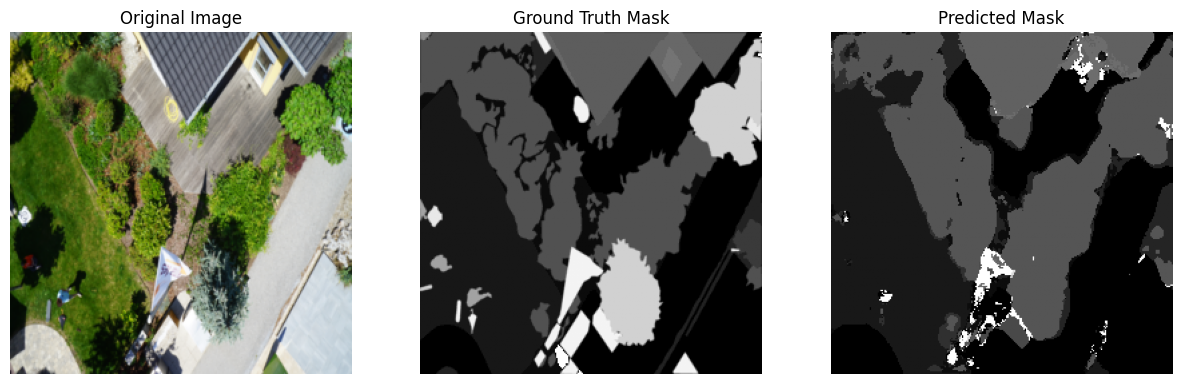

In [11]:
import random
import matplotlib.pyplot as plt

model.eval()
# Get some test samples
test_samples = random.sample(range(len(test_dataset)), 5)

for idx in test_samples:
    img, mask = test_dataset[idx]

    with torch.no_grad():
        pred_mask = model(img.unsqueeze(0).to(device))  # Forward pass

    pred_mask = torch.softmax(pred_mask, dim=1)  # Convert logits to probabilities
    pred_mask = pred_mask.argmax(dim=1).cpu().squeeze().numpy()  # Get class with highest probability

    # Display images
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(img.permute(1, 2, 0))
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(mask.squeeze(), cmap="gray")
    axes[1].set_title("Ground Truth Mask")
    axes[1].axis("off")

    axes[2].imshow(pred_mask, cmap="gray")  # Show class map
    axes[2].set_title("Predicted Mask")
    axes[2].axis("off")

    plt.show()